# Homework 4

## Preliminary Steps

We start the homework by importing the (many!) needed libraries and define functions that will help us later in the homework.

In [1]:
#We import the same libraries as in the 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, GridSearchCV, PredefinedSplit

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

%matplotlib inline

The first function allows us to draw custom charts (and display them inline to be able to get useful insights). This will be used a lot throughout Exercise 1.

In [2]:
#we use this a lot :D
def drawPies(u_rates, t_rates, labels, supertitle):
    """draws pretty comparative pie charts
    u_rates : rates for untreated group
    t_rates : rates for treated group
    lables: labels for values in rates
    supertitle: title of chart
    """
    fig = plt.figure(figsize=(7, 7))
    fig.suptitle(supertitle)
    
    plt.subplot(2,2,1)
    plt.pie(u_rates, labels = labels, autopct='%1.1f%%', shadow=True, startangle=90)
    plt.axis('equal')
    plt.title("control group")

    plt.subplot(2,2,2)
    plt.pie(t_rates, labels = labels, autopct='%1.1f%%', shadow=True, startangle=90)
    plt.axis('equal')
    plt.title("treated group")
    plt.show()

The second function we define is used to compare the interval variables (cf Exercises 1.02 and 1.04) of a DataFrame.

In [3]:
def interval_plots(df):
    """constructs boxplot and relative frequency histogram for data frame
    df: dataframe to be analyzed
    """
    #for each column draw a Boxplot
    for col in intervals:
        plt.figure(figsize=(10, 10))
        treated_ = df[treated(df)][col]
        untreated_ = df[untreated(df)][col]

        #boxplot
        plt.subplot(2,2,1)
        plt.title("Boxplot of " + col)
        plt.boxplot([untreated_, treated_], 
                    labels=['untreated', 'treated'], showfliers=False)
        plt.ylabel(col)

        #histogram
        plt.subplot(2,2,2)
        bins = np.linspace(min(df[col]), max(lalonde_df[col]), 50)
        plt.title("Relative frequency histogram of " + col)
        plt.ylabel('percentage')
        plt.xlabel(col)
        plt.hist(untreated_, weights=np.ones(len(untreated_))/len(untreated_), alpha=.5 , bins=bins)
        plt.hist(treated_, weights=np.ones(len(treated_))/len(treated_), alpha=.5, bins=bins)
        plt.legend(['untreated', 'treated'])

This final function is used in exercise 1.05 in order to compare the probabilities of categorical data between both groups (treated and untreated).

In [4]:
def compare_groups(table) :
    """
    Compares groups in merged dataframe
    table : dataframe to compare treated and untreated in
    """
    columns = ['untreated', 'treated']
    index = ['black', 'hisp', 'married', 'no_degree']
    result = pd.DataFrame(columns=columns, index=index)
    result['untreated']['black'] = table['black_y'].mean()
    result['untreated']['hisp'] = table['hispan_y'].mean()
    result['untreated']['married'] = table['married_y'].mean()
    result['untreated']['no_degree'] = table['nodegree_y'].mean()
    result['treated']['black'] = table['black_x'].mean()
    result['treated']['hisp'] = table['hispan_x'].mean()
    result['treated']['married'] = table['married_x'].mean()
    result['treated']['no_degree'] = table['nodegree_x'].mean()
    return result

## Exercise 1: Propensity Score Matching

The idea of this exercise is to analyze a dataset first without any real knowledge (naive analysis) and then through multiple processing steps to understand the data further.

We start by importing the data (and displaying it to understand the format).

In [5]:
lalonde_df = pd.read_csv('lalonde.csv')
lalonde_df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


Using this data, we can easily imagine that the first thing we need to do is split the salary data (_['re78']_) into 2 sets: treated and untreated. This will be useful throughout the exercise.

In [6]:
#masks to be used
treated = (lambda x: x.treat == 1)
untreated = (lambda x: x.treat == 0)

#mask application to the first DF
treated_salary = lalonde_df[treated(lalonde_df)]['re78']
untreated_salary = lalonde_df[untreated(lalonde_df)]['re78']

### 1. A naive analysis

We assume that a naive researcher unfamiliar with observational studies would treat the data as a randomized trial, not taking into consideration the hidden correlates.

**i - Describing the numbers**

We first look at the numbers to see how many subjects we have in each group and to see how the values are distributed.

In [7]:
lalonde_df.groupby('treat')['re78'].describe()

,count,mean,std,min,25%,50%,75%,max
treat,,,,,,,,
0,429.0,6984.169742,7294.161791,0.0,220.1813,4975.505,11688.820,25564.67
1,185.0,6349.143530,7867.402218,0.0,485.2298,4232.309,9642.999,60307.93


##### First insights:

- The untreated group has more people and their salaries have a higher mean.
- However, the 1st salary quartile is twice higher in the treated group and the maximum salary is 3x higher!
- We have that the 2nd and 3rd quartiles are higher in the untreated group. Quartiles are more resistent to outliers, hence indicating that the control group is faring better.
- Finally, the interquartile distance is larger in the untreated set (because of outliers). We use this measure because it is better to measure _'variance'_. Thus, we can say that the control group has a more heterogenous salary distribution.

**ii - Visualizing the data:**

We now plot the _['re78']_ salary data in a histogram (with equal sized bins) to find the distribution of salaries of the two groups. We add weights to be able to look at percentages instead of at the number of people in both groups (not equal, meaning it is not informative).

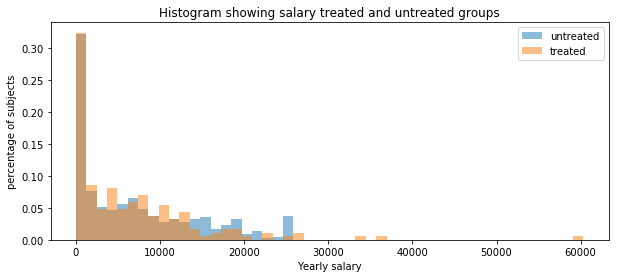

In [8]:
plt.figure(figsize=(10, 4))
bins = np.linspace(0, max(lalonde_df['re78']), 50)
plt.hist(untreated_salary, weights=np.ones(len(untreated_salary))/len(untreated_salary), alpha=.5 , bins=bins)
plt.hist(treated_salary, weights=np.ones(len(treated_salary))/len(treated_salary), alpha=.5, bins=bins)
plt.title('Histogram showing salary treated and untreated groups')
plt.legend(['untreated', 'treated'])
plt.xlabel('Yearly salary')
plt.ylabel('percentage of subjects')
plt.show()

##### Second insights:

We see a very similar distribution for both functions in the graph, except for the outliers present in the treated group. We also note that there are relatively more subjects in the untreated group with a salary between 10K and 20K while both groups have a similar ratio of subjects in the <10K section.

**iii - Boxplot:**

We use boxplots to illustrate the above number more concisely using a 5 number summary. Note that we remove outliers as we do not consider them to be representative of the outcome.

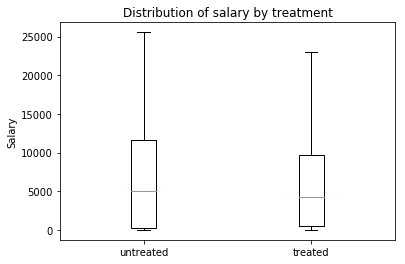

In [9]:
def outcome_by_treatment(untreated_salary, treated_salary):
    """draws boxplot of distribution of salary """
    plt.boxplot([untreated_salary, treated_salary], labels=['untreated', 'treated'], showfliers=False)
    plt.title('Distribution of salary by treatment')
    plt.ylabel('Salary')
    plt.show()

outcome_by_treatment(untreated_salary, treated_salary)

**Conclusion**:

If the treatment was effective, we should have noticed that the people in the treated group were more sucessful on average as they were placed in program (whereas for the untreated group, they were left to fend for themselves).

By merging the insights of his 3 steps analysis, the researcher can conclude that **the treatment shows no effect**. The salary distributions are similar in both groups, indicating that the treatment isn't effective.

Additionally, the treated group has a lower salary in average (except for the handful of lucky people who find a good job) which is shown by the boxplot: the whiskers extend higher in the untreated group and the median and lower wisker are situated higher up. Since the difference is somewhat small, this may just be due to chance.

### 2. A closer look at the data

After performing a simplistic analysis of the data where we ignored underlying factors (such as race and education) that could influence the outcome, we start looking at the whole table assuming that the other features have an impact on _['re78']_.

Note that we split our analysis into **categorical** and **interval** data (before determining the correlation between all variables).

**i - Categorical data :**

We can study the categorical data (race, degree and mariage) using their percentages in each population (as the treated and untreated groups have different sizes). To do this, we will simply use the mean of the values because averaging 0s and 1s gives us the percentage of each feature.

In [10]:
categories = ['black', 'hispan', 'married', 'nodegree']
percentages = lalonde_df.groupby('treat')[categories].mean()
percentages

,black,hispan,married,nodegree
treat,,,,
0,0.202797,0.142191,0.512821,0.596737
1,0.843243,0.059459,0.189189,0.708108


##### a. Race ratios:

We will start with race. As we do not have numbers for white participants, we substract the number of black and hispanic participants from the total of each treatment. This is possible because there is no overlap between the _['black']_ and _['hispan']_ categories.

In [11]:
black_u, black_t = percentages['black']
hispan_u, hispan_t = percentages['hispan']
white_u, white_t = (1 - black_u - hispan_u, 1 - black_t - hispan_t)

In [12]:
u_race_rates = [black_u, hispan_u, white_u]
t_race_rates = [black_t, hispan_t, white_t]
race_labels = 'Black', 'Hispanic', 'White'

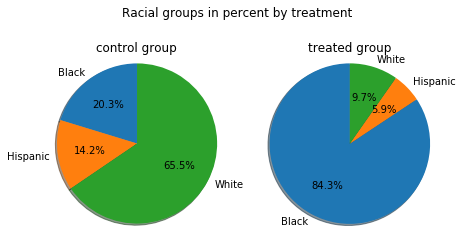

In [13]:
drawPies(u_race_rates, t_race_rates, race_labels, 'Racial groups in percent by treatment')

We see that there are significantly more black subjects in the treated group than in the untreated group. We also note that there are more hispanics in the untreated group.

##### b. Degree ratios:

To have a better understanding of the difference of salaries, we also need to look at the level of education of  participants in each treatment group.

In [14]:
degree_u, degree_t = percentages['nodegree']

In [15]:
u_degree_rates = [degree_u, 1 - degree_u]
t_degree_rates = [degree_t, 1 - degree_t]
degree_labels = 'Degree', 'No degree'

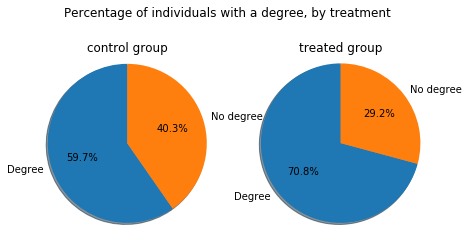

In [16]:
drawPies(u_degree_rates, t_degree_rates, degree_labels, 'Percentage of individuals with a degree, by treatment')

We notice that the population of treated group is less educated (there is over 10% more people with no degree in the treated set).

##### c. Marriage ratios:
Finally, we analyze our last feature: the rate of married people among both groups. 

In [17]:
married_u, married_t = percentages['married']
not_married_u, not_married_t = (1 - married_u, 1 - married_t)

In [18]:
u_marriage_rates = [married_u, not_married_u]
t_marriage_rates = [married_t, not_married_t]
mariage_labels = ['Married', 'Not married']

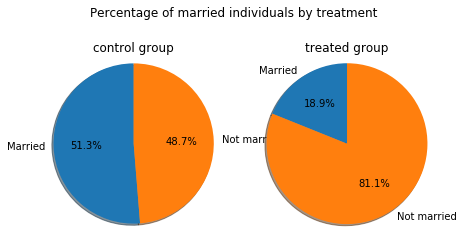

In [19]:
drawPies(u_marriage_rates, t_marriage_rates, mariage_labels, 'Percentage of married individuals by treatment')

We note once again less married people in the treated group.

##### d. Unemployment ratios:

Even though salaries are not categories but intervals, it is important to compare unemployment rates between both groups (which we define as categories: _employed_ and _unemployed_). To get better insights, we plot the evolution of this rate through the years by displaying _['re74']_ and _['re75']_.

In [20]:
salaries = ['re74', 're75']
cat_salaries = lalonde_df.copy()
unemployed_labels = 'Employed', 'Unemployed'

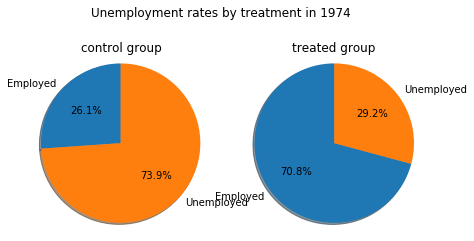

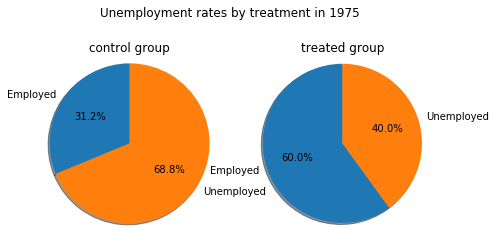

In [21]:
#We draw a boxplot for each column
for sal in salaries:
    #We classify the data following : employed = 1 and unemployed = 0
    cat_salaries[sal] = cat_salaries[sal].map(lambda x : 0 if x == 0 else 1)
    u_employed, t_employed = cat_salaries.groupby('treat')[sal].mean()
    drawPies([1-u_employed, u_employed],[1-t_employed, t_employed], 
             unemployed_labels, 'Unemployment rates by treatment in 19'+sal[-2:] )

We see that the assumption that both groups are balanced before treatment is also wrong for unemployment as we find much more unemployed people in the treated group than in the untreated group. 

**Conclusion:**

By looking at the categorical data, we find that the underlying factors are not similar at all among both groups (the treated group is significantly more black, less educated, less employed and less married). All these factors influence employment and should be taken into consideration.

These factors influence salary in the following ways:
- Due to racial inequality (especially given the period, the _1970s_), non-white people are more likely to work in worse paying jobs and/or be underpayed.
- Better education gets better jobs.
- People who already had jobs in 1974/5 are more likely to still have a job in 1978 (and may even have had a raise).
- Marriage is an indicator of stability, which may influence job prospects. People often get married when they have a stable job. 

**ii - Interval data :**

We now turn to non binary data and the their distribution to get more insights on the data. To do this, we first draw a boxplot and a relative fequency histogram for all variables.

_Note that we remove outliers from the box plot as we care more about the general distibution of values in the set._

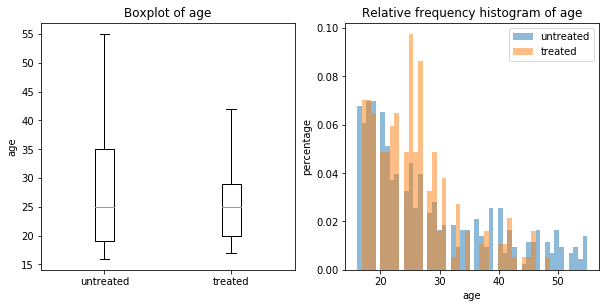

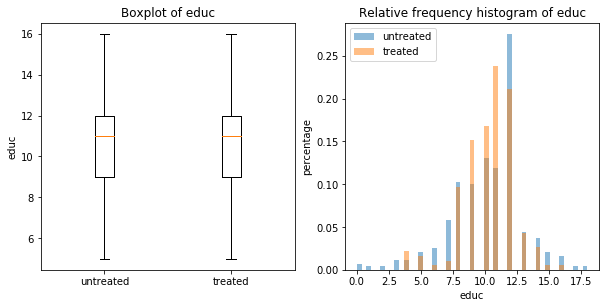

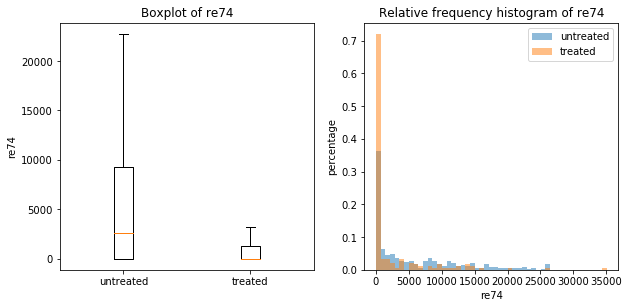

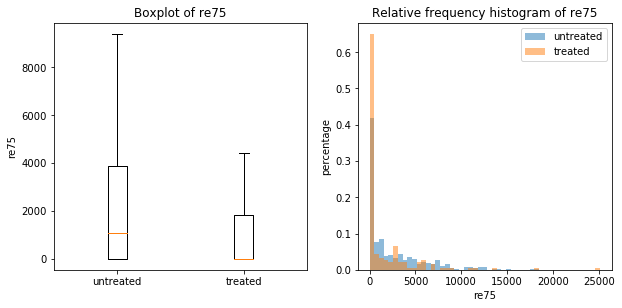

In [22]:
intervals = ['age', 'educ', 're74', 're75']
interval_plots(lalonde_df)

From these plots, we see that:
- Salaries are very unbalanced between the groups: the treatment group earns much less than the untreated group.
- The age distribution is different as the treated group is a bit younger (a lot of individuals are in their _20s_).
- Overall, the education level is similar. However, there are more well-educated people in the untreated group; we also note that the number of years of education does not indicate the acquirement of a degree.

##### a. Evolution:

Even though it is useful to plot the salaries through the years, it is much more useful to understand how the salary of each participant changes. It is especially interesting to see how the outliers in each year are connected. To do so, we visualize our data using a parallel plot (**orange** represents the treated group while **blue** represents the untreated group).

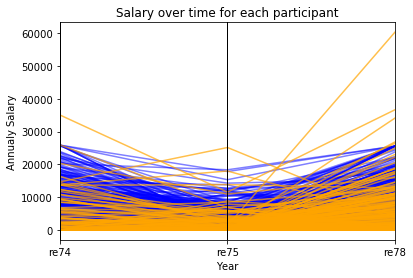

In [23]:
from pandas.plotting import parallel_coordinates
parallel_coordinates(lalonde_df[untreated(lalonde_df)][['id','re74', 're75', 're78']], 'id', color='Blue', alpha=0.5)
parplot = parallel_coordinates(lalonde_df[treated(lalonde_df)][['id','re74', 're75', 're78']], 'id', color='Orange' , alpha=0.7)
parplot.legend_.remove()
plt.title('Salary over time for each participant')
plt.xlabel('Year')
plt.ylabel('Annualy Salary')

Looking at the plots, we can that:
- The treated group started with a lower salary (the bracket of salaries up to 15K is all blue).
- 1975 was a "bad year" for everybody (there is an indent in the plot).
- The outliers are partially people who were already well payed in 1974 and partialy people who _"made it"_.
- Most members of the treated group have seen there salaries go up between 1975 and 1978. We also see a slight upwards movement for the untreated group.

#####  b. Salary and categorical features

As we supposed that categorical features influenced the salary, we try to see to what extent our hypothesis holds.

**Plotting by race:**

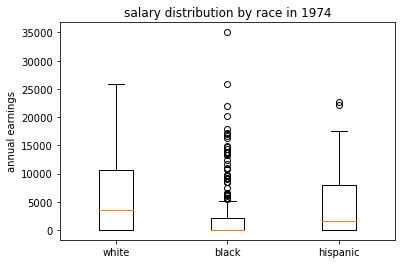

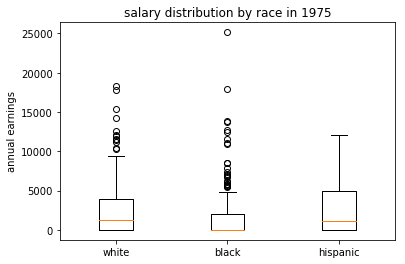

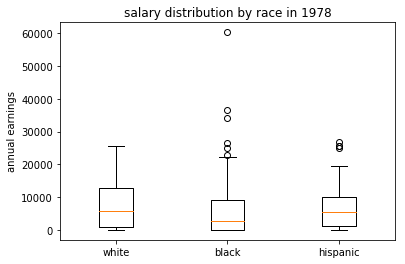

In [24]:
white = (lalonde_df['black'] == 0) & (lalonde_df['hispan'] == 0)
years = ['re74', 're75', 're78']

for year in years:
    plt.boxplot([lalonde_df[white][year], lalonde_df[lalonde_df['black'] == 1][year],
                 lalonde_df[lalonde_df['hispan'] == 1][year]], 
                labels=['white', 'black', 'hispanic'])
    plt.title('salary distribution by race in 19'+year[-2:])
    plt.ylabel('annual earnings')
    plt.show()

We can see that :
- There is a racial discrepancy in salary
- The outliers are all black individuals

**Plotting by martial status and degree:**

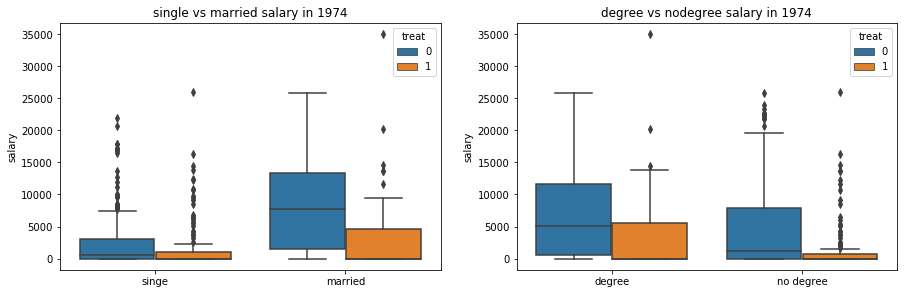

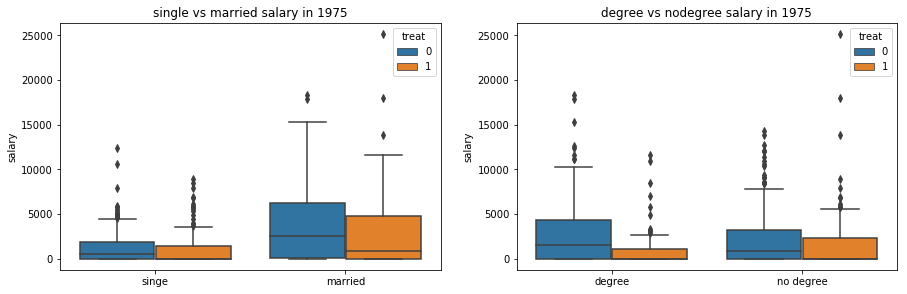

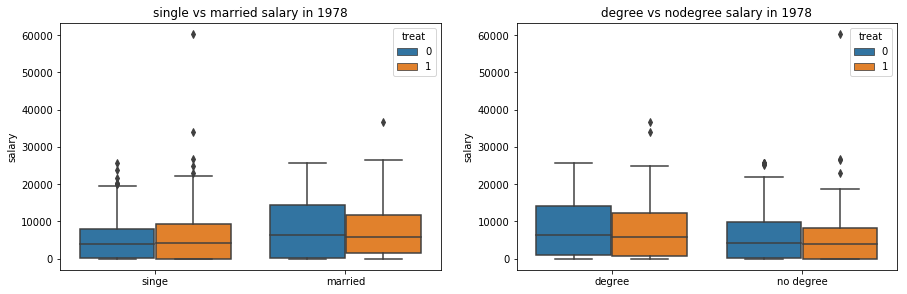

In [25]:
for year in years:
    #marriage
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.title('single vs married salary in 19'+year[-2:])
    sns.boxplot(data=lalonde_df, x='married', y=year, hue='treat')
    plt.ylabel('salary')
    plt.xlabel('')
    plt.xticks(range(2),('singe', 'married'))
    
    #degree
    plt.subplot(2,2,2)
    plt.title('degree vs nodegree salary in 19'+year[-2:])
    sns.boxplot(data=lalonde_df, x='nodegree', y=year, hue='treat')
    plt.xticks(range(2),('degree', 'no degree'))
    plt.xlabel('')
    plt.ylabel('salary')

We can see that no matter the treatment or the year, married people earn more than single people and people with degrees make more money that people with no degree.

**Plotting by age**


It is well known that age influences a person's prospects at finding a job but also influence their potential salary. Thus, we map the salary by age (and treatment) for the 3 observed years.

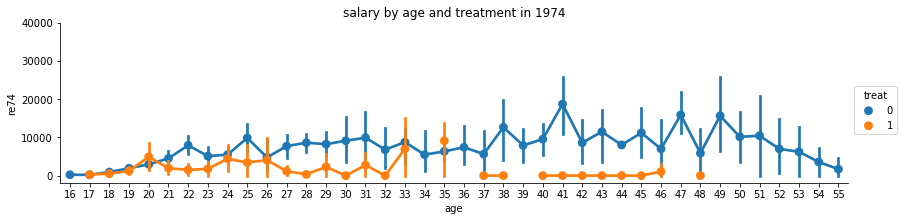

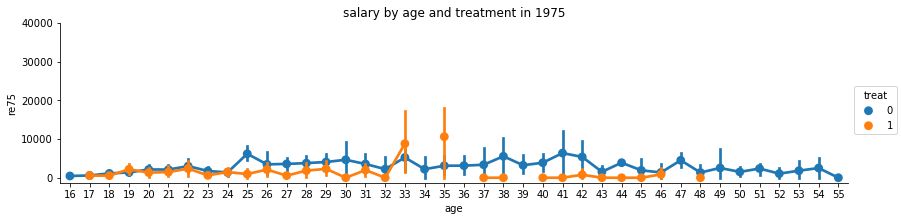

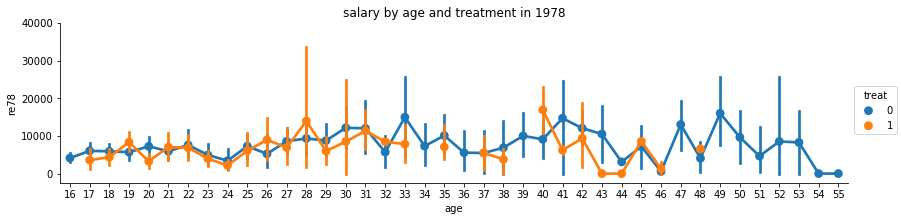

In [26]:
for year in years:
    sns.factorplot(data=lalonde_df, x='age', y=year, hue='treat',aspect=4, size=3)
    plt.title('salary by age and treatment in 19'+year[-2:])
    plt.yticks(np.linspace(0, 40000, 5))
    plt.show()

We can see that:

- Pre-treatment, the treated group makes less that the untreated group.
- Post-treatment, young people in the treated group easily catch up on people from the control group.
- The treatment seems to have an effect (in general, people in the treated group catch up, or at least find employment)

**Conclusion:**

By looking at the interval data, and more specificaly at the salaries of participants, we can say that the underlying feature (race, education, marital status) influence the salary. However, our two groups are not balanced which interferes with our first analysis.

**iii - Data correlation:**

After working on each value alone, we want to understand how each value is (linearly) linked to others looking at each pair of features. To do this, we draw as pairplot as correlation alone does not give us any insights.

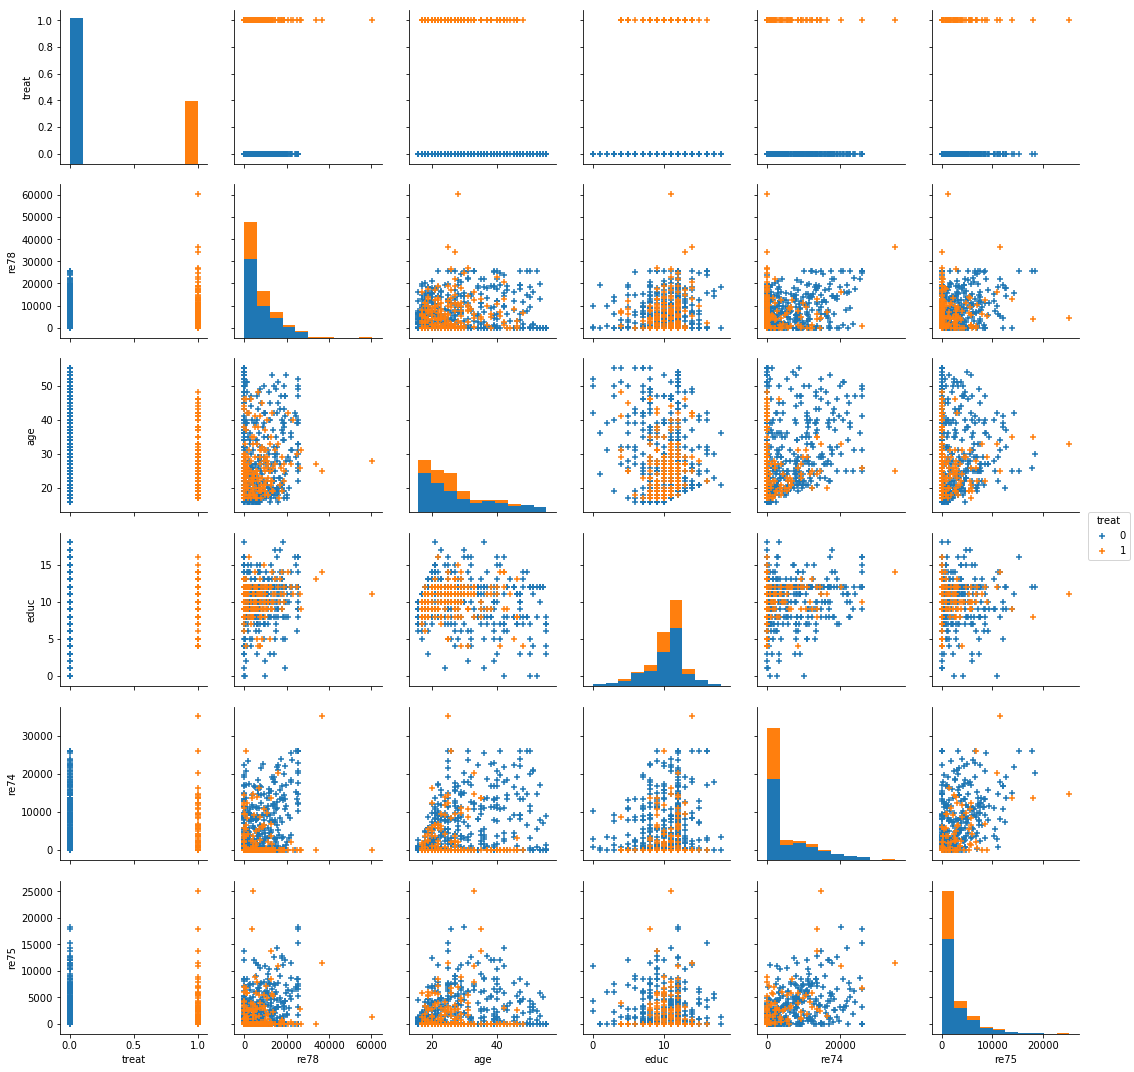

In [27]:
sns.pairplot(lalonde_df[['treat', 're78']+intervals], markers='+', hue='treat')

This plot does not tell us a lot other than the fact that we do not see any linear dependence. Thus, we do not spend more time on this part of our analysis.

### 3. A propensity score model

As we have seen, our naive analysis was based on the false assumption that the distribution was fair in both sets (which we determined was completely false). Thus, it is necessary to create fair sets for our observational study, which is what we do by calculating the propensity score (based on the underlying factors before treatment: _['age', 'educ', 'hispan', 'black', 'nodegree', 're74', 're75']_)

In [28]:
prop_table = lalonde_df.copy()
X = prop_table.iloc[:, 2:-1] #input: underlying features
y = np.ravel(prop_table.iloc[:, 1:2]) #output: treatment classification
print('First elements of Y :\n', y[0:5],'\nFirst elements of X :\n', X[0:5])

First elements of Y :
 [1 1 1 1 1] 
First elements of X :
    age  educ  black  hispan  married  nodegree  re74  re75
0   37    11      1       0        1         1   0.0   0.0
1   22     9      0       1        0         1   0.0   0.0
2   30    12      1       0        0         0   0.0   0.0
3   27    11      1       0        0         1   0.0   0.0
4   33     8      1       0        0         1   0.0   0.0


In [29]:
logistic = LogisticRegression()
logistic.fit(X, y)
print('Accuracy of prediction: ', logistic.score(X, y))

Accuracy of prediction:  0.807817589577


In [30]:
print("Example of prediction : ", logistic.predict(X[0:6]), ' reality :', y[0:6])
print('Example of prediction estimates : \n', logistic.predict_proba(X[0:6]))

Example of prediction :  [0 0 1 1 1 1]  reality : [1 1 1 1 1 1]
Example of prediction estimates : 
 [[ 0.55664958  0.44335042]
 [ 0.85534047  0.14465953]
 [ 0.27764537  0.72235463]
 [ 0.33584948  0.66415052]
 [ 0.30171439  0.69828561]
 [ 0.29988169  0.70011831]]


We add the propensity score as a new column. We can interpret this scores as the "probability of being a treated subject".

In [31]:
prop_table['propensity_scores'] = pd.Series(logistic.predict_proba(X)[:,1])
prop_table.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_scores
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


### 4. Balancing the dataset via matching

**i - Solving the bipartite graph problem:**

Using the propensity scores we just determined, we try to find a matching to interpret our data. This is nothing more than matching a bipartite graph to get a balanced set. Thus, we turn to _**networkx**_, a Python package which provides matching functions.

In [32]:
import networkx as nx

The first step of our solution is to create a graph where the _ids_ are the nodes.

In [33]:
B = nx.Graph()
B.add_nodes_from(prop_table['id'])

After this, we add (weighted) edges between each treated and untreated subject. The weight of each edge correponds to the (absolute) difference between the nodes.

_Note that we use '-x' to transform our minimization problem into a maximum problem to be able to use the **networkx** functions._

In [34]:
for row_i in prop_table[treated(prop_table)].iterrows():
    for row_j in prop_table[untreated(prop_table)].iterrows():
        B.add_edge(row_i[1]['id'],row_j[1]['id'], 
                   weight= 1 - np.abs(row_i[1].propensity_scores - row_j[1].propensity_scores))

Finally, we find the matching using a provided function. 

In [35]:
matching_dict = nx.max_weight_matching(B)

We display the number of matched subjects to be sure the method works indeed. We also display example matches to understand the form of the data.

_Note: we divide the length of the table by 2 as each pair is displayed twice._

In [36]:
matched = prop_table.copy()[prop_table['id'].isin(matching_dict)]
print('We have : ', len(matched)/2, ' matched subjects')

We have :  185.0  matched subjects


In [37]:
print('Example matches:')
list(matching_dict.items())[:5]

Example matches:


[('PSID240', 'NSW42'),
 ('NSW26', 'PSID225'),
 ('PSID131', 'NSW158'),
 ('NSW132', 'PSID423'),
 ('NSW76', 'PSID353')]

**ii - Looking at the salary:**

Now that our sets make more sense, we compare the outcome _['re78']_ of the treated and untreated groups using boxplots.

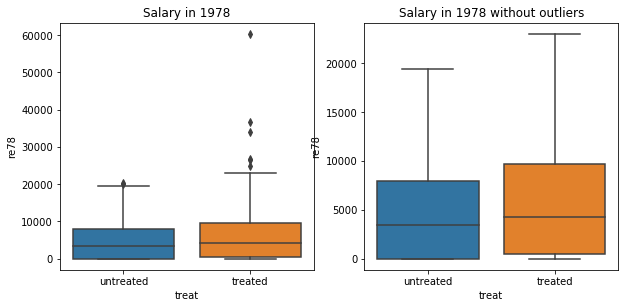

In [38]:
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
sns.boxplot(data=matched, x='treat', y='re78')
plt.xticks(range(2), ('untreated', 'treated'))
plt.title('Salary in 1978')
plt.subplot(2,2,2)
sns.boxplot(data=matched, x='treat', y='re78',  showfliers=False)
plt.xticks(range(2), ('untreated', 'treated'))
plt.title('Salary in 1978 without outliers')
plt.show()

Looking at the graph, we now see that the treated group's salary distribution in 1978 is slightly higher than that of the untreated group.

**iii - Looking at the feature distribution:**

The last part of this exercise is dedicated to analyzing the features just like we did in __Exercise 1.02__.

In [39]:
matched_percentages = matched.groupby('treat')[categories].mean()
matched_percentages

,black,hispan,married,nodegree
treat,,,,
0,0.470270,0.118919,0.167568,0.627027
1,0.843243,0.059459,0.189189,0.708108


Looking at our categorical data, we immediately see that the distribution of the features is skewed. Even though the racial distribution is the most blatant (almost 40% more blacks in the treated group), the other feature also differ quite consequently (from 2% to around 8%).

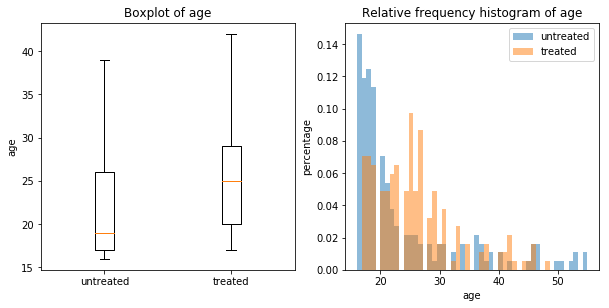

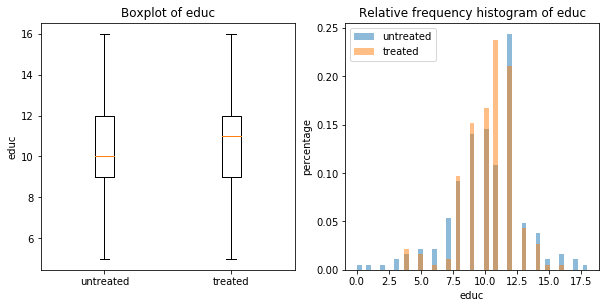

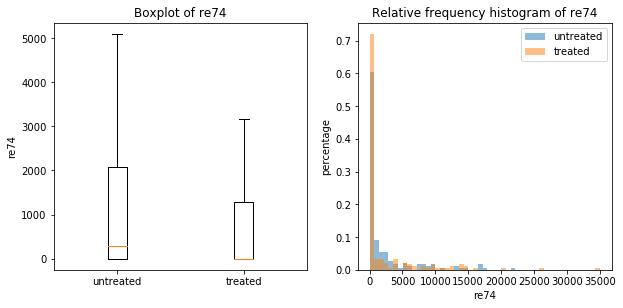

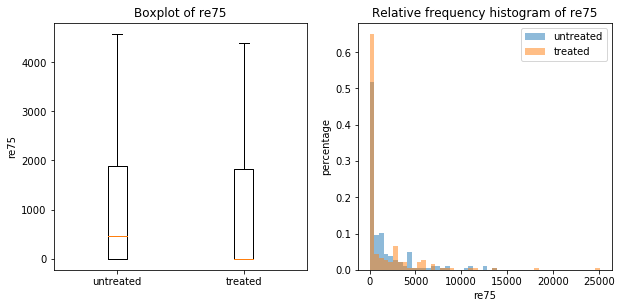

In [40]:
interval_plots(matched)

Now looking at the interval data, we see that is much more balanced than it was before, especially the education level of participants of both groups and their salary in 1975.

### 5. Balancing the groups further


Looking at the feature distribution following our propensity score matching, we can still see many discrepancies starting with the high ratio of black people remaining in the treated group comparing to the ratio in the untreated group. Additionally, we still have outliers in the treated group. This clearly means that our dataset is not sufficiently balanced yet.

**i - Merging the data:**


The first step of our balancing problem is to merge the DataFrames to work more easily with the data. We display the head of the new DataFrame for clarity (and display the number of matched subjects to make sure our matching makes sense).

In [41]:
matched['match'] = matched['id'].map(matching_dict)
balanced_match = matched[treated(matched)].merge(matched[untreated(matched)], left_on='id', right_on='match')
balanced_match['difference'] = abs(balanced_match['propensity_scores_x'] - balanced_match['propensity_scores_y'])
print('We have : ', len(balanced_match), ' matched subjects')
balanced_match.head()

We have :  185  matched subjects


,id_x,treat_x,age_x,educ_x,black_x,hispan_x,married_x,nodegree_x,re74_x,re75_x,...,black_y,hispan_y,married_y,nodegree_y,re74_y,re75_y,re78_y,propensity_scores_y,match_y,difference
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,...,0,0,0,1,0.00000,1491.339,237.914,0.155854,NSW1,0.287497
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,...,0,0,0,0,0.00000,0.000,0.000,0.143760,NSW2,0.000900
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,...,1,0,0,0,566.22810,0.000,2284.565,0.721966,NSW3,0.000389
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,...,0,0,0,0,80.32994,1890.581,6389.690,0.168512,NSW4,0.495639
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,...,0,1,0,0,1058.00400,0.000,8923.991,0.157910,NSW5,0.540376


We now compare the percentages of each feature in both groups to determine the problematic features. 

In [42]:
compare_groups(balanced_match)

,untreated,treated
black,0.47027,0.843243
hisp,0.118919,0.0594595
married,0.167568,0.189189
no_degree,0.627027,0.708108


**ii - Matching by race:**

As expected, the first improvement we need to make has to do with race. To do this, we remove mismatched black people (meaning black people who are matched to another race, either white or hispanic). It is also important to monitor the evolution of the dataset.

In [43]:
race_bool = (balanced_match['black_x'] == 1) & (balanced_match['black_y'] == 0)
balanced_match = balanced_match.drop(balanced_match[race_bool].index)
print('We have : ', len(balanced_match), ' matched subjects')

We have :  116  matched subjects


In [44]:
compare_groups(balanced_match)

,untreated,treated
black,0.75,0.75
hisp,0.0689655,0.0948276
married,0.267241,0.163793
no_degree,0.646552,0.681034


**iii - Matching by marriage:**

When looking at the new dataset, we see a clear difference in the rate of married people between the untreated and the treated group. This is consistant with what we noticed earlier when looking at the data. Thus, it is very important to remove mismatched married people.

In [45]:
marriage_bool = (balanced_match['married_x'] == 1) & (balanced_match['married_y'] == 0)
balanced_match = balanced_match.drop(balanced_match[marriage_bool].index)
print('We have : ', len(balanced_match), ' matched subjects')

We have :  114  matched subjects


In [46]:
compare_groups(balanced_match)

,untreated,treated
black,0.754386,0.754386
hisp,0.0614035,0.0877193
married,0.27193,0.149123
no_degree,0.649123,0.684211


We can now see that all features are similar (except for a low difference in the rate of hispanics across both groups). However, we deem the categorical data of our dataset to be balanced enough for the matching to make sense.

**iv - Looking at intervals and outliers:**

Now that we know our categorical data is balanced, we need to make sure the interval data is still constistent across our groups. However, we still need to perform an important task for the data to be meaningful: we need to remove the outliers (which create a discrepancy on the mean of our data).

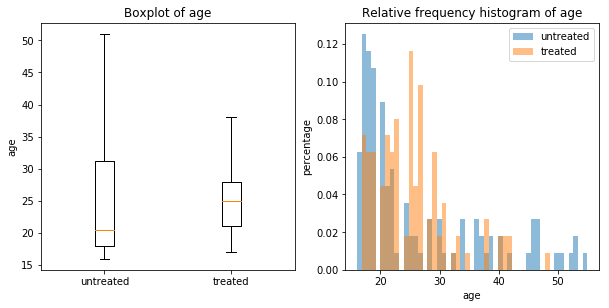

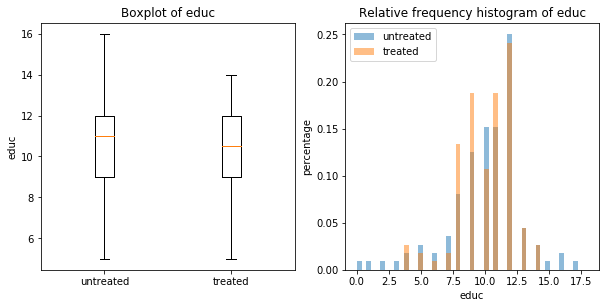

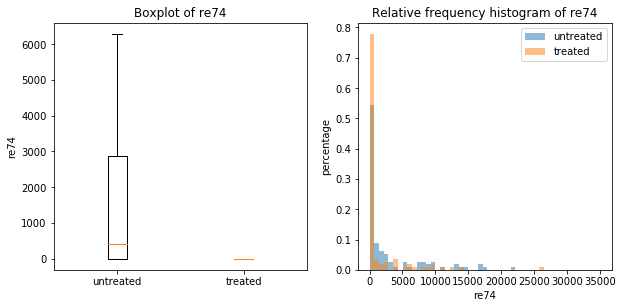

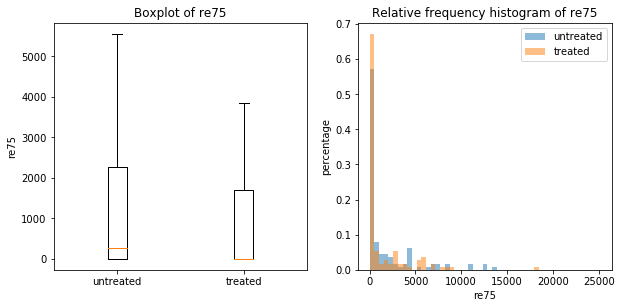

In [47]:
def plot_balanced_interval(df):
    df1 = df.iloc[:,:11]
    df2 = df.iloc[:, 13:-3]
    df2.columns = lalonde_df.columns
    df1.columns = lalonde_df.columns
    balanced_df = pd.concat([df1, df2])
    interval_plots(balanced_df)
    
balanced_match = balanced_match.drop(balanced_match[balanced_match.re78_x > 30000].index)
plot_balanced_interval(balanced_match)

Looking at the (more robust) statistics of our interval data, we see very similar distributions over almost features, the age being the main difference between both sets. Once again, we assume this difference to be of minor significance, allowing us to use the dataset for our analysis as we can finally compare people with similar features.

### 6. A less naive analysis

Knowing that we compare (almost) perfectly matched groups, we only need to look at the distribution of _['re78']_, the outcome we wanted to analyze all along. To interpret our data, we use a 5 number summary (along with its visual representation, our faithful boxplot).

In [48]:
stats = pd.concat([balanced_match.re78_y.describe(),balanced_match.re78_x.describe()], axis=1)
stats.columns = ['untreated', 'treated']
stats

,untreated,treated
count,112.000000,112.000000
mean,5063.918156,5845.192579
std,6218.176728,6344.361400
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1944.688500,4255.961000
75%,8340.658000,9135.511000
max,20243.380000,26817.600000


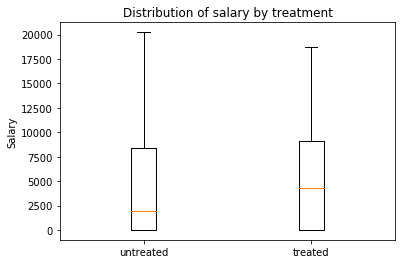

In [49]:
outcome_by_treatment(balanced_match['re78_y'], balanced_match['re78_x'])

Looking at the graph and the numbers, it is clear that **the treatment has a benefic impact** on people. These observations are all the more significant as they are performed on similar panels.

On top of having a higher mean and a smaller standard deviation, the quartiles of the treated population are all superior to those of the untreated population. Moreover, the median is significantly higher in the treated group, and so is the maximum salary.

## Exercise 2: Applied ML

In this exercise we build a text classifier and analyze it's preformance.

## 1. Transforming the Data

First, we need to compute the TF-IDF features of our dataset, using a vectorizer. As we understood the question, it was not asked to use any of the given datasets from sklearn, but to use all of the data. Thus, we do not use the train and test subsets given to us in sklearn, but will create our own such subsets, adding a validation subset.

Also note that we **remove the headers, footers and quotes**, as proposed in the <a href="http://scikit-learn.org/stable/datasets/twenty_newsgroups.html">sklearn tutorial</a> of the dataset, as to have something more realistic and without any of the metadata. 
This significantly decreases our accuracy, as we show later in section 3.

Note also that we did not use the *sklearn.datasets.fetch_20newsgroups_vectorized* function that returns the TF-IDF features directly, as it would defeat the purpose of the exercise.

In [ ]:
# create the TF-IDF vectorizer
tfidf = TfidfVectorizer()

In [ ]:
# Import the data we need to use the vectorizer on. Remove metadata as proposed by sci-kit tutorial
newsgroups_all = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
newsgroups_with_header = fetch_20newsgroups(subset='all')

As asked in the question, before seperating in subsets, we will use the vectorizer on the complete set.

In [ ]:
# vectors is a sparse matrix
X = tfidf.fit_transform(newsgroups_all.data)

Now we need to seperate the dataset into three sets: train, test and validation.

In [ ]:
# first we seperate train from the rest. Random_state given to have a seed.
y_train, y_inter, X_train, X_inter = \
    train_test_split(newsgroups_all.target, X, test_size=0.2, random_state=1)

# then we seperate again to get validation and test seperately
y_test, y_valid, X_test, X_valid = \
    train_test_split(y_inter, X_inter, test_size=0.5, random_state=1)

## 2. Training the classifier

Now we need to train a random forest on our training set. For this, we will use the RandomForestClassifier, as it contains the parameters talked about in the exercise. But first, we need to ask ourselves what we want to set the parameters (*max_depth* and *n_estimators*) to.

We set the two parameters to get a first idea on what values we will get for the prediction.
We use 100 trees and a depth of 25, values that are similar to the ones given in the course.

For the predictions, we can't use the training set, as we just trained on it and thus would get very good results regardless of the goodness of fit. So prediction has to be on the validation set.

We use two measure the goodness of our system to the data by two measures, F1 score and prediction accuracy.

In [ ]:
# need to find estimators and depth first.
clf = RandomForestClassifier(n_estimators=100, max_depth=25)
clf.fit(vect_train, newsgroups_train)
pred = clf.predict(vect_valid)
metrics.f1_score(newsgroups_valid, pred, average='macro')

In [ ]:
print('F1 score for basic parameters : ',metrics.f1_score(y_valid, pred, average='macro'))

In [ ]:
print('Accuracy for basic parameters : ', metrics.accuracy_score(y_valid, pred))

As we can see, predictions aren't that great.

We try to fine tune on the validation set. We first used skikit's GridSearchCV function, but could not find the right parameters to make the function work perfectly. 
In fact, the best parameters were almost always the highest ones, yet the results of predictions stayed quite poor.

Thus, we decided to use a double for loop, implementing the grid search. Even if this type of computation is very heavy and takes a lot more time aswell.

Please note that finding a good fit over a large range of values takes a lot of time to compute, as there are a very large numbers of estimators.

In [ ]:
# We made a few tries already to determine which values yield better results.
# We have a double for loop. Which is aweful and will take a lot of time, but necessary.
def GridSearch(X_train, y_train, X_valid, y_valid, range_estimator, range_depth):
    """Implements grid search, goes over range_estimator and range_depth, returns best parameter in the ranges
    X_train: set to train on
    y_train: true values training
    X_valid: set to test on
    y_valid: true values for testing
    range_estimator: range to go over for estimator
    range_depth: range to go over for depth
    """
    rows = []
    for i in range_estimator: #making sure the depth is not better above 30
        for j in range_depth: #step of 100 to not take too much time
            clf = RandomForestClassifier(n_estimators=j, max_depth=i, n_jobs=-1)
            clf.fit(X_train, y_train)
            pred = clf.predict(X_valid)
            pred_result = metrics.accuracy_score(y_valid, pred)
            # uncomment next line to be able to know where computation is at
            print(i," ; ", j)
            rows.append([i, j, pred_result])
    # We create a DF to be able to use all this data effectively
    columns=['Depth', 'Estimators', 'Prediction']
    all_predictions = pd.DataFrame(rows, columns=columns) # we get all the predictions in a dataframe
    # we sort by best prediction
    all_predictions = all_predictions.sort_values(by=['Prediction'], ascending=False)
    # we show the best 10
    return all_predictions.head(5)

In [ ]:
#all_predictions = GridSearch(X_train, y_train, X_valid, y_valid, range(30, 160, 30), range(300, 1100, 200))

We previously run the loop overnight and saved the findings into a pickle file:

In [ ]:
# Saving the pickle. Do not run if we did not make a new pandas.
# all_predictions.to_pickle("all_predictions.pkl")
# read the pickle.
all_predictions = pd.read_pickle("all_predictions.pkl")
all_predictions.head(10)

We quickly visualize the points in the file to get an overview

In [ ]:
fig = plt.figure(figsize=(7,7))
plt.suptitle('Depth, Estimator and precision accuracy')
plt.subplot(2,2,1)
plt.ylabel('precision accuracy')
plt.scatter(all_predictions['Depth'], all_predictions['Prediction'])
plt.xlabel('depth')
plt.subplot(2,2,2)
plt.scatter(all_predictions['Estimators'], all_predictions['Prediction'])
plt.xlabel('number of estimators')
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(all_predictions['Depth'], all_predictions['Estimators'], all_predictions['Prediction'])
ax.set_title('3d plot of estimators depth and precision relationship')
ax.set_xlabel('depth')
ax.set_ylabel('number of estimators')
ax.set_zlabel('prediction accuracy')

As we can see, te best resuts are when *n_estimators* is set around 700 and *max_depth* is set at 130. Note that because we have a bit of randomness, the results are not deterministic.

We note that tutorials on the internet show 80% and more accuracy for random forest classifiers, where as we only get 68%.
This is because we have taken out all metadata, as asked for by the tutorial on sklearn. Thus, we have more realistic predictions and results. To show this, let us compare predictions with and without metadata in section 3.

In [ ]:
clf = RandomForestClassifier(n_estimators=700, max_depth=130, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
pred = clf.predict(X_valid)

In [ ]:
print('F1 score for basic parameters : ', metrics.f1_score(y_valid, pred, average='macro'))

In [ ]:
print('Accuracy for basic parameters : ', metrics.accuracy_score(y_valid, pred))

Now we do a confusion matrix on the test set.

In [ ]:
pred_test = clf.predict(X_test)
#get confusion matrix
cm = metrics.confusion_matrix(y_test, pred_test)
df = pd.DataFrame(cm)
#renaming for convenience
df.columns = newsgroups_all.target_names
df.index = newsgroups_all.target_names

To be able to read this matrix, lets put it into a DataFrame and add the right column names, then show the heatmap.

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Confusion matrix')
sns.heatmap(df, cmap='OrRd', annot=True, cbar=False)
plt.ylabel('predicted label')
plt.xlabel('true label')
plt.show()

The diagonal shows us the true positives. we see that some classes have higher prediction accuracy than others.
Our classifier classifies sport.hockey very well but has great trouble classifying talk.religious.misc correctly.

Then the mixups (false negatives & false positives) are within similar topics, such as religion.muisc & religion.christian –this is a false negative, the classifier assigned talk.religion.misc but the true lable is talk.religion.misc .

Now, let us inspect the `feature_importances_` attribute of our random forest.

In [ ]:
#most significant features
features = pd.DataFrame(list(zip(tfidf.get_feature_names(), clf.feature_importances_)))
features = features.sort_values(by=[1], ascending=False)
features.head(10)

It is not suprising to see keywords such as car or god in this list, as they clearly indicate a topic. A text containing god will more likely be religous.

In [ ]:
#Worst still positive 
features = features.sort_values(by=[1], ascending=True)
features[features[1] > 0].head(10)

Some of the least indicative still indicative features are very cryptic, they probably only show up in one text, but strongly indicate the type of text.

We now look at te most relevant features in relation to each other:

In [ ]:
feature_importance = pd.Series(clf.feature_importances_).sort_values(ascending=False)

In [ ]:
plt.bar(range(0, 200),feature_importance.head(200))
plt.title('feature impotance for most relevant features')
plt.xlabel('feature rank')
plt.ylabel('importance')
plt.show()

We note that the first are very relevant, and the the slope of relevancy slowly goes down.

Let us also have an idea of how many features are important or not by plotting them:

In [ ]:
plt.hist(clf.feature_importances_, bins=50)
#note the log scale!
plt.yscale('log')
plt.title(' histogram for feature importance')
plt.xlabel('importance by feature')
plt.ylabel('Number of features (log)');

We see that very few features are very important, while most are useless.

### 3. Prediction with lables

We now show how much better the prediction is if we keep the lables in the dataset.

We prefrom the same data processing as before:

In [ ]:
# vectors is a sparse matrix
X = tfidf.fit_transform(newsgroups_with_header.data)

# first we seperate train from the rest. Random_state given to have a seed.
y_train, y_inter, X_train, X_inter = \
    train_test_split(newsgroups_with_header.target, X, test_size=0.2, random_state=1)

# then we seperate again to get validation and test seperately
y_test, y_valid, X_test, X_valid = \
    train_test_split(y_inter, X_inter, test_size=0.5, random_state=1)

We make the assumption that the estimators on both sets will be similar

In [ ]:
clf = RandomForestClassifier(n_estimators=700, max_depth=130, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
pred = clf.predict(X_valid)

In [ ]:
print('F1 score for basic parameters : ', metrics.f1_score(y_valid, pred, average='macro'))

In [ ]:
print('Accuracy for basic parameters : ', metrics.accuracy_score(y_valid, pred))

We immeditely see that the results are much better.

In [ ]:
pred_test = clf.predict(X_test)
#get confusion matrix
cm = metrics.confusion_matrix(y_test, pred_test)
df = pd.DataFrame(cm)
#renaming for convenience
df.columns = newsgroups_all.target_names
df.index = newsgroups_all.target_names

To be able to read this matrix, lets put it into a DataFrame and add the right column names, then show the heatmap.

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Confusion matrix')
sns.heatmap(df, cmap='OrRd', annot=True, cbar=False)
plt.ylabel('predicted label')
plt.xlabel('true label')
plt.show()

We see that compared to the previous confusion matrix we have a lot more true positives and less false negatives & false positives.

The features that were hard to label before still get labeled incorrectly.

Now, let us inspect the `feature_importances_` attribute of our random forest for this classifier:

In [ ]:
#most significant features
features = pd.DataFrame(list(zip(tfidf.get_feature_names(), clf.feature_importances_)))
features = features.sort_values(by=[1], ascending=False)
features.head(10)

In [ ]:
#Worst still positive 
features = features.sort_values(by=[1], ascending=True)
features[features[1] > 0].head(10)

We see that the unsignificant features are more nonsensical than before and the significant features stay similar, although there is some change.

We now look at te most relevant features in relation to each other:

In [ ]:
feature_importance = pd.Series(clf.feature_importances_).sort_values(ascending=False)

In [ ]:
plt.bar(range(0, 200),feature_importance.head(200))
plt.title('feature impotance for most relevant features')
plt.xlabel('feature rank')
plt.ylabel('importance')
plt.show()

We note that the first are very relevant, and the the slope of relevancy is a lot more steep than in the above case.
We thus have a very few very relevant features, an less lesser relevant features.

Let us also have an idea of how many features are important or not by plotting them in a histogram:

In [ ]:
plt.hist(clf.feature_importances_, bins=50)
#note the og scale!
plt.yscale('log')
plt.title(' histogram for feature importance')
plt.xlabel('importance by feature')
plt.ylabel('Number of features (log)');

We see that the feature importance distributon does not change a lot by adding metadata to the set.
Unsignificant and significant features are however more separated compared to the features obtained before and the distribution is sightly shifted to the left.